<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 10.1: Introduction to AWS SageMaker and Managed Services




### Introduction
In this lab you will be introduced to some Amazon Web Services with access via an AWS Educate Starter account. Notably, you will see how to work with Jupyter notebooks in a SageMaker session, make use of cloud storage through an S3 bucket and explore several demos related to image recognition and text analysis.

Note that this notebook will need to be loaded into an AWS SageMaker instance under a `conda_python3` environment in order to be run succesfully.

At a later date after signing into the console you may navigate to https://console.aws.amazon.com/cost-management/home, then select "Explore Costs" then "Service" to see a breakdown of costs by AWS service for recent days. This will ensure that you are not still being charged for any services that were unintentionally not terminated after this module's labs.

### 1. Connecting to AWS via AWS Educate

AWS Educate provides IOD students with access to $30 credits of access to many of Amazon's Web Services without requiring credit card details. The course coordinator will have provided you access to AWS Educate.

a) Accept the invitation to AWS Educate using the link provided in your email.

b) Sign in to https://www.awseducate.com and navigate to the "Classrooms & Credits" tab, then "Request or go to an AWS Educate Classroom".

c) Select "My classrooms" and then the "Go to classroom" link that appears under "Courses where I am a Student".

d) You will be redirected to a https://labs.vocareum.com page. Vocareum is an external provider that maintains the provisioning of AWS Educate Starter accounts. You should see "Welcome to your AWS Educate Account" where you can see your remaining credits (initialised to $30) and remaining session time of 2:60 (3 hours which can be extended). 

If the 3 hours runs out, simply reload the Workbench page and click again on the AWS Console button.

e) Click "AWS Console" and you will be directed to your AWS console.

f) Spend a few moments familiarising yourself with this page noting the extensive list of AWS services within categories such as Compute, Machine Learning, Storage and Analytics. All of these are documented at https://docs.aws.amazon.com/. Note that the $30 credit starts to be consumed when you start up services such as S3 (storage) and SageMaker (Jupyter notebooks) and not by simply browing the console.

### 2. Creating an Amazon SageMaker notebook instance

a) From the console select "Amazon SageMaker". From the left select "Notebook instances". https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/notebook-instances

b) Click the orange button "Create notebook instance" and enter a Notebook instance name of your choice.

c) Keep the notebook instance type as `ml.t2.medium` (this incurs a cost of about 4 cents per hour). 

d) Under "Permissions and encryption" - IAM role, select "create a new IAM role" if you do not have one already. This is a set of permissions to make AWS service requests. More information about IAM (Identity & Access Management) can be found at https://aws.amazon.com/iam/faqs/.

e) All other options may be left at their default settings. Note that there is also the option to clone a public git repository to this notebook instance but we will not be doing this here. Finally select "Create notebook instance" at the bottom of the page.

f) It usually takes a few minutes for the instance to be ready as the status changes from "Pending" to "InService". Then you may click on "Open Jupyter" and you will be taken to a familiar jupyter dashboard view. You may browse through a number of SageMaker example notebooks by selecting the "SageMaker Examples" tab. Any of these can either be previewed or used. Note however that training machine learning models requires additional permissions beyond what AWS Educate provides.

### 3. Using SageMaker and S3

Upload this notebook into your AWS SageMaker instance under a `conda_python3` environment.

#### Import libraries

In [1]:
import pandas as pd
from skimage import io
from io import BytesIO
import urllib.request
from matplotlib import pyplot as plt
import boto3 #AWS API
from zipfile import ZipFile

The boto3 library allows access to AWS APIs via wrapper functions.

Clients provide low-level access to Amazon Web Services. Resources are higher level with more object-oriented readable syntax providing less functionality than clients. Examples of resources include or S3 buckets (storage) or EC2 instances (computing).

In [2]:
s3 = boto3.client('s3')
s3_resource = boto3.resource('s3')

Running the cell below should confirm that your SageMaker instance is in the us-east-1 region.

In [3]:
my_region = boto3.session.Session().region_name 
print("Success - my SageMaker instance is in the " + my_region + " region.")

Success - my SageMaker instance is in the us-east-1 region.


Next we create an S3 bucket (container) into which we will place data. Files within buckets are accessed by keys. Hence note that while dir1/f1 and dir1/f2 are keys referencing two files, f1 and f2 are not interpreted as files contained within dir1. 

In [4]:
my_bucket_name = '91winw' # <--- CHANGE THIS TO A UNIQUE NAME FOR YOUR BUCKET (no uppercase letters)

In [5]:
try:
    if  my_region == 'us-east-1':
        s3_resource.create_bucket(Bucket=my_bucket_name)
    else: 
        s3_resource.create_bucket(Bucket=my_bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


Verify that a bucket was created also by viewing the S3 console at https://console.aws.amazon.com/s3.

**Exercise**: Fill in the missing code to list your S3 buckets.

In [6]:
response = s3.list_buckets()

# Output the bucket names
print('Existing buckets:')
for bucket in response['Buckets'] :
    print(f'{bucket["Name"]}') 

Existing buckets:
91winw
aws-logs-718842131893-us-east-1


The following code allows one to list the contents of a bucket along with file sizes.

In [7]:
# Function from https://github.com/aws-samples/aws-open-data-analytics-notebooks/blob/master/exploring-data/README.md

def list_bucket_contents(bucket, match='', size_mb=0):
    bucket_resource = s3_resource.Bucket(bucket)
    total_size_gb = 0
    total_files = 0
    match_size_gb = 0
    match_files = 0
    for key in bucket_resource.objects.all():
        key_size_mb = key.size/1024/1024
        total_size_gb += key_size_mb
        total_files += 1
        list_check = False
        if not match:
            list_check = True
        elif match in key.key:
            list_check = True
        if list_check and not size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')
        elif list_check and key_size_mb <= size_mb:
            match_files += 1
            match_size_gb += key_size_mb
            print(f'{key.key} ({key_size_mb:3.0f}MB)')

    if match:
        print(f'Matched file size is {match_size_gb/1024:3.1f}GB with {match_files} files')            
    
    print(f'Bucket {bucket} total size is {total_size_gb/1024:3.1f}GB with {total_files} files')

We will investigate the contents of a bucket from the Registry of Open Data on AWS. A listing of these datasets is at https://registry.opendata.aws/. In particular we shall make use of the COCO image dataset (Common Objects in Context), used for object detection and segmentation. From https://registry.opendata.aws/fast-ai-coco/ we see that the bucket name is `fast-ai-coco`. 

In [8]:
list_bucket_contents(bucket='fast-ai-coco')

annotations_trainval2017.zip (241MB)
coco_sample.tgz (3096MB)
coco_tiny.tgz (  1MB)
giga-fren.tgz (2478MB)
image_info_test2017.zip (  1MB)
image_info_unlabeled2017.zip (  5MB)
panoptic_annotations_trainval2017.zip (821MB)
stuff_annotations_trainval2017.zip (1095MB)
test2017.zip (6339MB)
train2017.zip (18441MB)
unlabeled2017.zip (19194MB)
val2017.zip (778MB)
Bucket fast-ai-coco total size is 51.3GB with 12 files


Next, we copy the `val2017.zip` file (containing 5000 images) to the bucket you created above via the following function.

In [9]:
def copy_to_bucket(origin_bucket_name, destination_bucket_name, file_name):
    copy_source = {
        'Bucket': origin_bucket_name,
        'Key': file_name
    }
    s3_resource.Object(destination_bucket_name, file_name).copy(copy_source)

**Exercise**: Use the above function to copy val2017.zip to your bucket. Then use the list_bucket_contents function to verify that the 'val2017.zip' was successfully transferred. Alternatively, use the S3 console.

In [10]:
copy_to_bucket('fast-ai-coco', '91winw', 'val2017.zip')

In [11]:
list_bucket_contents(bucket='91winw')

val2017.zip (778MB)
Bucket 91winw total size is 0.8GB with 1 files


S3 is a storage location that does not allow computation. The following code allows us to extract selected files.

In [12]:
zip_obj = s3_resource.Object(bucket_name= my_bucket_name, key='val2017.zip')
buffer = BytesIO(zip_obj.get()["Body"].read())
z = ZipFile(buffer)

Here is a list of the files contained in the zip file.

In [13]:
for filename in z.namelist():
    print(filename)

val2017/
val2017/000000212226.jpg
val2017/000000231527.jpg
val2017/000000578922.jpg
val2017/000000062808.jpg
val2017/000000119038.jpg
val2017/000000114871.jpg
val2017/000000463918.jpg
val2017/000000365745.jpg
val2017/000000320425.jpg
val2017/000000481404.jpg
val2017/000000314294.jpg
val2017/000000335328.jpg
val2017/000000513688.jpg
val2017/000000158548.jpg
val2017/000000132116.jpg
val2017/000000415238.jpg
val2017/000000321333.jpg
val2017/000000081738.jpg
val2017/000000577584.jpg
val2017/000000346905.jpg
val2017/000000433980.jpg
val2017/000000228144.jpg
val2017/000000041872.jpg
val2017/000000117492.jpg
val2017/000000368900.jpg
val2017/000000376900.jpg
val2017/000000352491.jpg
val2017/000000330790.jpg
val2017/000000384850.jpg
val2017/000000032735.jpg
val2017/000000197004.jpg
val2017/000000526751.jpg
val2017/000000041488.jpg
val2017/000000153632.jpg
val2017/000000501523.jpg
val2017/000000405691.jpg
val2017/000000040757.jpg
val2017/000000219485.jpg
val2017/000000428280.jpg
val2017/00000020

We select a sample of these image files for transfer to our SageMaker instance.

In [14]:
list_of_files = ['007108', '008021', '023781', '024021', '052412', '060855', '062808', '071938', '104424', '108495',
              '138115', '170474', '246308', '280891', '324258', '325483', '336232', '402765', '494913']

In [15]:
for filename in z.namelist():
    if filename[-10:-4] in list_of_files:
        file_info = z.getinfo(filename)
        s3_resource.meta.client.upload_fileobj(
            z.open(filename),
            Bucket=my_bucket_name,
            Key=f'{filename}'
        )

**Exercise**: Verify that contents of your S3 bucket have been modified.

In [16]:
list_bucket_contents(bucket='91winw')

val2017.zip (778MB)
val2017/000000007108.jpg (  0MB)
val2017/000000008021.jpg (  0MB)
val2017/000000023781.jpg (  0MB)
val2017/000000024021.jpg (  0MB)
val2017/000000052412.jpg (  0MB)
val2017/000000060855.jpg (  0MB)
val2017/000000062808.jpg (  0MB)
val2017/000000071938.jpg (  0MB)
val2017/000000104424.jpg (  0MB)
val2017/000000108495.jpg (  0MB)
val2017/000000138115.jpg (  0MB)
val2017/000000170474.jpg (  0MB)
val2017/000000246308.jpg (  0MB)
val2017/000000280891.jpg (  0MB)
val2017/000000324258.jpg (  0MB)
val2017/000000325483.jpg (  0MB)
val2017/000000336232.jpg (  0MB)
val2017/000000402765.jpg (  0MB)
val2017/000000494913.jpg (  0MB)
Bucket 91winw total size is 0.8GB with 20 files


Next we copy the jpg files from your S3 bucket to the local instance for viewing.

In [17]:
for f in list_of_files:
    new_file_name =  f + '.jpg'
    bucket_file_name = 'val2017/000000' + new_file_name
    s3.download_file(my_bucket_name, bucket_file_name, new_file_name)

Similarly the ``upload_file`` method can be used to upload local files to the bucket.

**Exercise**: Use the imshow and imread methods to plot some or all the images.

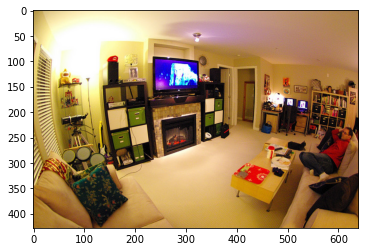

In [18]:
for file in list_of_files:
    plt.imshow(io.imread(file + '.jpg'))

The following command can be used to save the files in one archive file. This makes it more convenient to download the images at once. Alternatively one can download the entire (5000-file) archive at https://s3.amazonaws.com/fast-ai-coco/val2017.zip.

In [19]:
#save file to local machine
!tar chvfz photos.tar.gz *.jpg

007108.jpg
008021.jpg
023781.jpg
024021.jpg
052412.jpg
060855.jpg
062808.jpg
071938.jpg
104424.jpg
108495.jpg
138115.jpg
170474.jpg
246308.jpg
280891.jpg
324258.jpg
325483.jpg
336232.jpg
402765.jpg
494913.jpg


### Working with files from a url or your local machine

As with your Jupyter notebooks that run locally on your machine, SageMaker notebooks can also work with files from the internet or your local machine.

**Exercise**: Read in a data file from a url and display the first few lines to verify it loaded successfully.

In [20]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)

('winequality-red.csv', <http.client.HTTPMessage at 0x7f999bbe1a90>)

In [21]:
df = pd.read_csv(filename, sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


**Exercise**: Upload a file from your DATA folder used in this course. Display the first five rows to verify that it was loaded successfully.

In [24]:
filename = 'Wisconson_breast_cancer.csv'
df = pd.read_csv(filename)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


Note that your free AWS Educate Starter account gives you the ability to explore datasets, but not to train or deploy models.

### 4. Amazon Rekognition via the Console

Go the Amazon Rekognition console page by searching for Rekogntion, or go directly to https://console.aws.amazon.com/rekognition/home?region=us-east-1#/. From there click on "Try Demo" to see a series of image recognition capabilities ranging from "Object and Scene Detection" to "Text in Image". In addition to the samples there you may wish to try either your own examples or the following files that we downloaded above:

- for Object and Scene Detection: 007108, 008021, 023781, 024021, 052412, 060855, 062808, 071938, 246308, 280891, 336232, 494913 
- for Facial Analysis: 104424, 108495, 138115
- for Celebrity Recognition: 170474
- for Face Comparison: 324258, 325483
- for Text in Image: 402765

Performing these actions via the API rather than the console requires additional access, such as an Amazon Free Tier account (which requires a credit card).

### 5. Amazon Textract via the Console

Go through the following 10-minute demo to understand the features and capabilities of Amazon Textract to extract text from documents.

https://aws.amazon.com/getting-started/hands-on/extract-text-with-amazon-textract/

In addition to the same data provided, you may wish to use the files `amzn_stock.pdf` and `sample_form.JPG` from the DATA folder.

### 6. Amazon Comprehend via the Console

Go through the following 10-minute demo to understand the features and capabilities of Amazon Comprehend for text analysis.

https://aws.amazon.com/getting-started/hands-on/analyze-sentiment-comprehend/

### 7. Closing your notebook instance and deleting your S3 bucket

Run the following cell to delete your bucket.

In [ ]:
bucket_to_delete = s3_resource.Bucket(my_bucket_name)
bucket_to_delete.objects.all().delete()

Verify that the bucket has been emptied by navigating to https://console.aws.amazon.com/s3/. You may then delete the bucket by selecting it in the S3 console page and clicking "Delete".

Download this notebook to your local machine when you are done. Then stop your notebook instance by visiting https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/notebook-instances, selecting the instance and then choosing "Stop" under the "Actions" menu.



---



---



> > > > > > > > > © 2021 Institute of Data


---



---



